<a href="https://colab.research.google.com/github/jesto05/Machine-Learning/blob/main/Custom_Informer_Sample_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
#!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 576 (delta 181), reused 176 (delta 176), pack-reused 378 (from 1)
Receiving objects: 100% (576/576), 6.48 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Global_Local_5min  Informer2020  sample_data


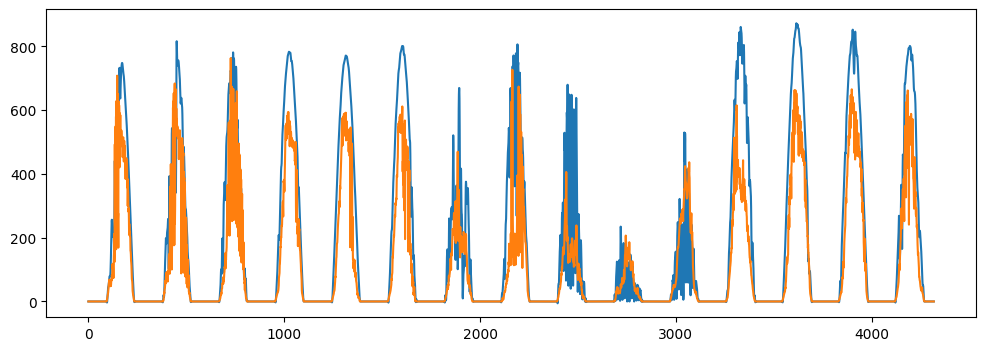

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df=pd.read_csv('Global_Local_5min.csv')
plt.figure(figsize=(12, 4))
plt.plot(df['Global_5'])
plt.plot(df['Local_5'])

In [3]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [54]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [91]:
args = dotdict()

args.model = 'informer'  # You can change the model as needed

args.data = 'custom'  # A custom name for your dataset
args.root_path = './'  # The directory where your CSV is located
args.data_path = 'Global_Local_5min.csv'  # The file name of your custom dataset
args.features = 'MS'  # You are using multivariate features (Global_5 and Local_5)
args.target = 'Local_5'  # The target feature
args.freq = 't'  # Since your data is 5 minutes, you should use 't' (minutely)
args.checkpoints = './informer_checkpoints'

# Set other parameters (these can be adjusted as needed for your experiment)
args.seq_len = 864  # You can adjust this depending on how much history you want to consider
args.label_len = 576  # You can adjust this based on your use case
args.pred_len = 288  # How many steps ahead you want to predict

args.enc_in = 2  # Number of input features (Global_5, Local_5)
args.dec_in = 2  # Decoder input size (same as encoder input size)
args.c_out = 1  # Output size (since you have 1 target, Local_5)
args.factor = 5  # Prob sparse attention factor, you can adjust this
args.d_model = 512  # Model dimension, adjust based on your experiment
args.n_heads = 8  # Number of attention heads
args.e_layers = 2  # Number of encoder layers
args.d_layers = 1  # Number of decoder layers
args.d_ff = 2048  # Dimension of fully connected layers
args.dropout = 0.05  # Dropout rate
args.attn = 'prob'  # Attention mechanism (use probabilistic attention)
args.embed = 'timeF'  # Time feature encoding method
args.activation = 'gelu'  # Activation function
args.distil = True  # Whether to use distilling in the encoder
args.output_attention = False  # Whether to output attention weights
args.mix = True
args.padding = 0

args.batch_size = 32  # Adjust batch size as needed
args.learning_rate = 0.0001  # Learning rate
args.loss = 'mse'  # Loss function (mean squared error)
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6  # Number of training epochs
args.patience = 3  # Early stopping patience
args.des = 'exp'


args.use_gpu = True if torch.cuda.is_available() else False  # Use GPU if available
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [92]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

# Time encoding setup
timeenc = 0 if args.embed != 'timeF' else 1

# Set dataset flag, shuffle, batch size, etc.
flag = 'train'  # Change to 'test' or 'val' as needed
shuffle_flag = True  # Shuffle data
drop_last = True  # Drop last batch if necessary
batch_size = 1  # Use the batch size defined in args IF NEEDEED

# Initialize dataset
data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=args.freq
)

# Initialize data loader
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last
)

# Check dataset length and data loader length
print(f"Dataset size: {len(data_set)}")
print(f"Data loader size: {len(data_loader)}")


Dataset size: 864
Data loader size: 864


In [93]:
# Experiment setup for training and testing
from exp.exp_informer import Exp_Informer

exp = Exp_Informer(args)

# Setting for the experiment
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, 0)

# Set up experiment
exp = Exp_Informer(args)

# Train the model
print(f'Starting training with setting: {setting}')
exp.train(setting)

# Test the model
print(f'Starting testing with setting: {setting}')
exp.test(setting)


Use CPU
Use CPU
Starting training with setting: informer_custom_ftMS_sl864_ll576_pl288_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp
train 864
val 2
test 289
Epoch: 1 cost time: 1307.7980241775513
Epoch: 1, Steps: 27 | Train Loss: 0.9915203 Vali Loss: nan Test Loss: 0.8598201
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 1306.320536851883
Epoch: 2, Steps: 27 | Train Loss: 0.7242714 Vali Loss: nan Test Loss: 0.4944641
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 1293.8176448345184
Epoch: 3, Steps: 27 | Train Loss: 0.2928377 Vali Loss: nan Test Loss: 0.1362422
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 1266.371192932129
Epoch: 4, Steps: 27 | Train Loss: 0.0861447 Vali Loss: nan Test Loss: 0.0534959
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning

In [106]:
# Prediction after training
setting = 'informer_custom_ftMS_sl864_ll576_pl288_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp'

exp = Exp_Informer(args)
exp.predict(setting, True)

# Load and plot predictions
import numpy as np
import matplotlib.pyplot as plt

prediction = np.load(f'./results/{setting}/pred.npy')
true = np.load(f'./results/{setting}/true.npy')

plt.figure(figsize=(12, 6))
# Example to visualize the first prediction sequence
plt.plot(prediction[0, :, -1])
plt.plot(true[0, :, -1])
plt.legend(['Prediction', 'True'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs True')

plt.show()


Use CPU


TypeError: 'NoneType' object is not subscriptable